In [1]:
import numpy as np
import pandas as pd
import gensim as gs
import nltk

from sys import stdout
import time
import pickle

In [2]:
from sklearn.metrics import roc_auc_score, average_precision_score

### Read data

In [29]:
data_raw = pd.read_csv('data/eur-lex/eurlex_data.txt', delimiter=', "|"', header=None, engine='python').drop(2, 1)
y_raw = pd.read_csv('data/eur-lex/eurlex_labels.txt', sep=' ', header=None).drop(2, 1)

In [30]:
data_raw = data_raw[data_raw[0].isin(y_raw[1].unique())]

# Data processing

In [5]:
from nltk.stem import snowball as sb

In [31]:
docs_splitted = [sent.decode('utf-8').split() for sent in data_raw.values[:, 1]]
docs_str = [sent.decode('utf-8') for sent in data_raw.values[:, 1]]

In [3]:
y = pd.get_dummies(y_raw).groupby(1).sum()

In [4]:
del y_raw

#### Stemming and filtering

In [7]:
%%time
stemmers = [sb.EnglishStemmer(), sb.FrenchStemmer(), sb.GermanStemmer(),
            sb.ItalianStemmer(), sb.SpanishStemmer()]
stopwords = frozenset(sb.stopwords.words())
stemmed_data = docs_splitted
data_len = len(stemmed_data)
_start0 = time.time()
for stemmer in stemmers[:1]:
    print str(stemmer)
    stemmed_data_ = []
    for i, sent in enumerate(stemmed_data):
        tmp = []
        for w in sent:
            if w not in stopwords:
                tmp += [stemmer.stem(w)]
        stdout.write('\r{}/{}: {:.2f}%, {:.2f} sec.'.format(i, data_len, 100. * (i + 1) / data_len, time.time() - _start0))
        stemmed_data_ += [tmp]
    stemmed_data = stemmed_data_
    print ''

<EnglishStemmer>
19313/19314: 100.00%, 426.59 sec.
CPU times: user 8min 2s, sys: 1min 21s, total: 9min 24s
Wall time: 7min 6s


In [9]:
for stemmer in stemmers:
    del stemmer

del stemmers, stemmed_data_, stopwords, docs_splitted

#### Lemmatizing

In [8]:
%%time
lemm_data = []
data_len = len(stemmed_data)
stopwords = set(nltk.corpus.stopwords.words())
_start = time.time()
for i, sent in enumerate(stemmed_data):
    lemm_data += [gs.utils.lemmatize(' '.join(sent))]
    stdout.write('\r{}/{}: {:.2f}%, {:.2f} sec.'.format(i, data_len, 100. * (i + 1) / data_len, time.time() - _start))
    if i == 100:
        break
print ''

100/19314: 0.52%, 31.52 sec.
CPU times: user 32 s, sys: 0 ns, total: 32 s
Wall time: 31.5 s


In [32]:
diff = np.array([len(doc) - len(sent) for sent, doc in zip(stemmed_data, docs_splitted)])

In [33]:
plt.rcParams['font.size'] = 15

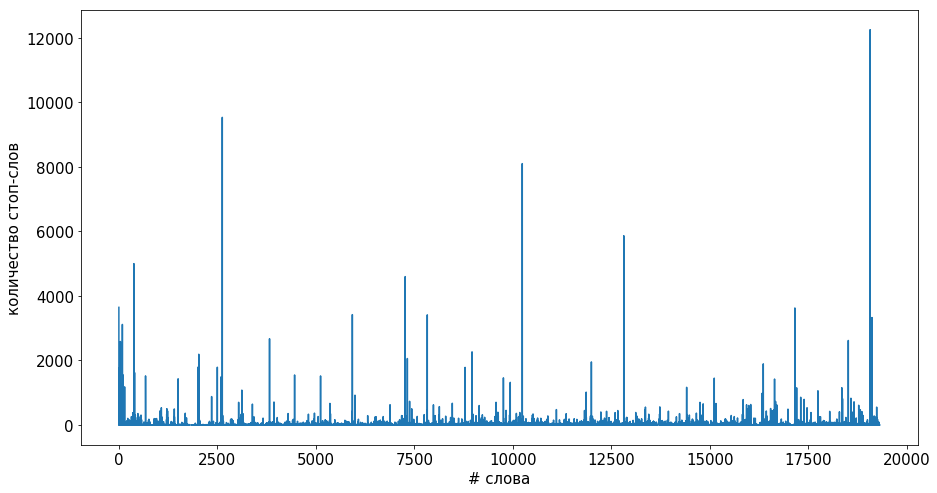

In [34]:
plt.figure(figsize=(15, 8))
plt.plot(diff)
plt.xlabel(u'# слова')
plt.ylabel(u'количество стоп-слов')
plt.savefig('pics/diff.pdf', bbox_inches='tight')
plt.show()

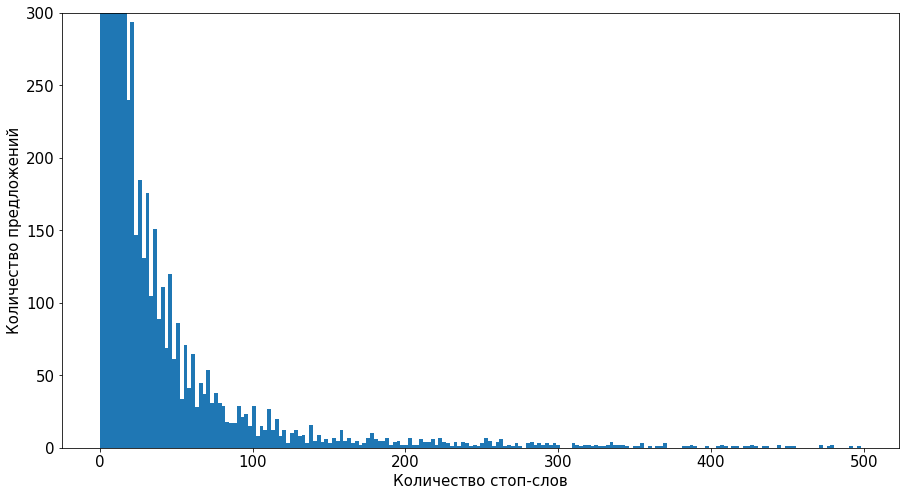

In [35]:
plt.figure(figsize=(15, 8))
plt.hist(diff[diff < 500], bins=200)
# plt.xlim((0, 100))
plt.ylim((0, 300))
plt.xlabel(u'Количество стоп-слов')
plt.ylabel(u'Количество предложений')
plt.savefig('pics/diff_dist.pdf', bbox_inches='tight')
plt.show()

# Feature extraction

In [11]:
sentences = stemmed_data
del stemmed_data

In [ ]:
# pickle.dump(sentences, open('data/sentences.pkl', 'w'))

In [7]:
# sentences = pickle.load(open('data/sentences.pkl'))

In [8]:
ids = [i for i in data_raw.values[:, 0]]

In [9]:
del data_raw

In [9]:
import matplotlib.pyplot as plt

### Word2Vec

In [32]:
w2v_size = 300
%time w2v = gs.models.Word2Vec(sentences, size=w2v_size)

CPU times: user 4min 23s, sys: 880 ms, total: 4min 24s
Wall time: 1min 33s


In [33]:
X_w2v = np.zeros((len(sentences), w2v_size))
for i, sent in enumerate(sentences):
    X_w2v[i] = np.mean([w2v[word] for word in sent if word in w2v], axis=0)

In [34]:
del w2v

In [35]:
# pickle.dump(X_w2v, open('data/X_w2v.pkl', 'w'))

In [9]:
# X_w2v = pickle.load(open('data/X_w2v.pkl'))

### Topic modeling

In [10]:
dic = gs.corpora.Dictionary(sentences)
corpus = [dic.doc2bow(sent) for sent in sentences]
tm_size = 300

In [11]:
%time lda = gs.models.LdaModel(corpus=corpus, id2word=dic, num_topics=tm_size)

CPU times: user 25min 31s, sys: 31min 44s, total: 57min 16s
Wall time: 19min 52s


In [12]:
# pickle.dump(lda, open('data/lda.pkl', 'w'))

In [13]:
X_tm = np.zeros((len(sentences), tm_size))
for i, sent in enumerate(corpus):
    X_tm[i] = map(lambda x: x[1], lda.get_document_topics(sent, minimum_probability=0))

In [11]:
# pickle.dump(X_tm, open('data/X_tm.pkl', 'w'))

In [10]:
# X_tm = pickle.load(open('data/X_tm.pkl'))

### Doc2Vec

In [36]:
class LabeledSentences(object):
    def __init__(self, sentences, ids):
        self.sentences = sentences
        self.ids = ids

    def __iter__(self):
        for uid, sent in zip(self.ids, self.sentences):
            yield gs.models.doc2vec.LabeledSentence(words=sent, tags=['SENT_%s' % uid])

In [37]:
docs = LabeledSentences(sentences, ids)

In [38]:
d2v_size = 300
%time d2v = gs.models.Doc2Vec(docs, size=d2v_size)

CPU times: user 4min 36s, sys: 1.2 s, total: 4min 38s
Wall time: 1min 42s


In [39]:
X_d2v = np.zeros((len(sentences), d2v_size))
for i, sent in enumerate(sentences):
    X_d2v[i] = np.mean([d2v[word] for word in sent if word in d2v], axis=0)

In [40]:
del d2v

In [41]:
# pickle.dump(X_d2v, open('data/X_d2v.pkl', 'w'))

In [11]:
# X_d2v = pickle.load(open('data/X_d2v.pkl'))

### Tf-idf

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
tfidf = TfidfVectorizer()

In [44]:
X_tfidf = tfidf.fit_transform([' '.join(sent) for sent in sentences])

In [45]:
from sklearn.decomposition import TruncatedSVD

In [47]:
svd = TruncatedSVD(n_components=300)

In [48]:
X_tfidf = svd.fit_transform(X_tfidf)

In [49]:
# pickle.dump(X_tfidf, open('data/X_tfidf.pkl', 'w'))

In [12]:
# X_tfidf = pickle.load(open('data/X_tfidf.pkl'))

# Classification

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_idx, test_idx = train_test_split(np.arange(X_d2v.shape[0]), test_size=0.1)

In [67]:
# pickle.dump(train_idx, open('data/train_idx.pkl', 'w'))
# pickle.dump(test_idx, open('data/test_idx.pkl', 'w'))

In [11]:
# train_idx = pickle.load(open('data/train_idx.pkl'))
# test_idx = pickle.load(open('data/test_idx.pkl'))

In [16]:
from sklearn.multiclass import OneVsRestClassifier

In [27]:
def doc_auc_roc(y_true, y_pred):
    return np.mean([roc_auc_score(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)])

In [28]:
def doc_auc_pr(y_true, y_pred):
    return np.mean([average_precision_score(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)])

### LogRess

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
clf = OneVsRestClassifier(LogisticRegression(), n_jobs=-1)

#### w2v

In [50]:
%%time
clf.fit(X_w2v[train_idx], y.values[train_idx])

/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 51 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 76 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 100 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 113 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 177 is present in all training examples.
  str(classes[c]))
/

/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2492 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2503 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2534 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2535 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2614 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2700 is present in all training examples.
  str(class

CPU times: user 5min 9s, sys: 1.27 s, total: 5min 10s
Wall time: 27min 31s


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=-1)

In [52]:
y_w2v = clf.predict_proba(X_w2v[test_idx])

In [53]:
# pickle.dump(y_w2v, open('data/y_w2v.pkl', 'w'))

In [54]:
doc_auc_roc(y.values[test_idx], y_w2v)

0.97129482623464158

In [55]:
doc_auc_pr(y.values[test_idx], y_w2v)

0.52899322566044282

#### topic modeling

In [22]:
%%time
clf.fit(X_tm[train_idx], y.values[train_idx])

/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 51 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 76 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 100 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 113 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 177 is present in all training examples.
  str(classes[c]))
/

/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2492 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2503 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2534 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2535 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2614 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2700 is present in all training examples.
  str(class

CPU times: user 5min 3s, sys: 1.76 s, total: 5min 5s
Wall time: 12min 22s


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=-1)

In [23]:
y_tm = clf.predict_proba(X_tm[test_idx])

In [24]:
# pickle.dump(y_tm, open('data/y_tm.pkl', 'w'))

In [25]:
doc_auc_roc(y.values[test_idx], y_tm)

0.92817090222591936

In [26]:
doc_auc_pr(y.values[test_idx], y_tm)

0.26927755885558363

#### d2v

In [56]:
%%time
clf.fit(X_d2v[train_idx], y.values[train_idx])

/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 51 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 76 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 100 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 113 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 177 is present in all training examples.
  str(classes[c]))
/

/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2492 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2503 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2534 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2535 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2614 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2700 is present in all training examples.
  str(class

CPU times: user 5min 10s, sys: 1.3 s, total: 5min 11s
Wall time: 21min 30s


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=-1)

In [57]:
y_d2v = clf.predict_proba(X_d2v[test_idx])

In [58]:
# pickle.dump(y_d2v, open('data/y_d2v.pkl', 'w'))

In [59]:
doc_auc_roc(y.values[test_idx], y_d2v)

0.97101338012710647

In [60]:
doc_auc_pr(y.values[test_idx], y_d2v)

0.51168665056381291

#### tf-idf

In [61]:
%%time
clf.fit(X_tfidf[train_idx], y.values[train_idx])

/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 51 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 76 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 97 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 100 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 113 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 177 is present in all training examples.
  str(classes[c]))
/

/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2492 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2503 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2534 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2535 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2614 is present in all training examples.
  str(classes[c]))
/home/ospanoff/.venvs/python2/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2700 is present in all training examples.
  str(class

CPU times: user 5min 12s, sys: 1.15 s, total: 5min 13s
Wall time: 13min 13s


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=-1)

In [62]:
y_tfidf = clf.predict_proba(X_tfidf[test_idx])

In [63]:
# pickle.dump(y_tfidf, open('data/y_tfidf.pkl', 'w'))

In [64]:
doc_auc(y.values[test_idx], y_tfidf)

0.95058798301373015

In [65]:
doc_auc_pr(y.values[test_idx], y_tfidf)

0.44940426056703281

### Class comparison

In [51]:
y_w2v = pickle.load(open('data/y_w2v.pkl'))
y_tm = pickle.load(open('data/y_tm.pkl'))
y_d2v = pickle.load(open('data/y_d2v.pkl'))
y_tfidf = pickle.load(open('data/y_tfidf.pkl'))

In [52]:
y_names = np.array([name.split('_', 1)[1] for name in y.columns])

In [77]:
def compare_classes(doc_idx, y_true, y_preds, names, n=5, thold=None):
    """
    Args:
        n: number of top classes
        thold: threshold (if None n is used)
    """
    y_t = y_true[doc_idx]
    print "true y:", names[np.where(y_t == 1)[0]]
    for i, y_pred in enumerate(y_preds):
        y_p = y_pred[doc_idx]
        
        y_sorted_idx = np.argsort(y_p)[::-1]
        if thold is None:
            print "pred y, {}:".format(i), names[y_sorted_idx[:n]]
        else:
            print "pred y, {}:".format(i), names[y_sorted_idx][y_p[y_sorted_idx] > thold]

In [89]:
compare_classes(0, y.values, [y_w2v, y_tm, y_d2v, y_tfidf], y_names)

true y: ['ec_agreement' 'environmental_cooperation' 'environmental_protection'
 'pollution_control_measures' 'rhine_valley']
pred y, 0: ['ec_cooperation_agreement' 'united_states' 'economic_cooperation'
 'ec_agreement' 'cooperation_agreement']
pred y, 1: ['ec_agreement' 'protocol_to_an_agreement' 'ec_cooperation_agreement'
 'ec_association_agreement' 'trade_agreement']
pred y, 2: ['ec_cooperation_agreement' 'economic_cooperation' 'united_states'
 'eu_country' 'cooperation_agreement']
pred y, 3: ['ec_cooperation_agreement' 'ec_agreement' 'eu_country'
 'economic_cooperation' 'cooperation_policy']


# Visualization

### LDA

In [2]:
sentences = pickle.load(open('data/sentences.pkl'))
dic = gs.corpora.Dictionary(sentences)

In [3]:
dic.filter_extremes()
dic.compactify()

In [4]:
corpus = [dic.doc2bow(sent) for sent in sentences]

In [5]:
del sentences

In [6]:
%time lda = gs.models.ldamodel.LdaModel(corpus=corpus, id2word=dic, num_topics=100)

CPU times: user 6min 40s, sys: 16min 35s, total: 23min 16s
Wall time: 4min 12s


In [7]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [8]:
vis_data = gensimvis.prepare(lda, corpus, dic)
pyLDAvis.display(vis_data)

In [10]:
pyLDAvis.save_html(vis_data, 'pics/lda.html')

In [11]:
# pickle.dump(lda, open('data/lda_vis.pkl', 'w'))

### Word2Vec

In [37]:
from sklearn.manifold import TSNE

In [38]:
import matplotlib.pyplot as plt

In [5]:
sentences = pickle.load(open('data/sentences.pkl'))

In [40]:
%time w2v = gs.models.Word2Vec(stemmed_data)

CPU times: user 3min 3s, sys: 673 ms, total: 3min 4s
Wall time: 1min 8s


In [41]:
tsne = TSNE()

In [42]:
TOPN = 40

In [43]:
chosen_words = [u'color', u'mobil', u'onion']

In [44]:
X_w2v_names = []
for cw in chosen_words:
    X_w2v_names += [cw] + map(lambda x: x[0], w2v.most_similar(cw, topn=TOPN))

In [45]:
X_w2v = [w2v[name] for name in X_w2v_names]

In [61]:
X_w2v_tsne = tsne.fit_transform(X_w2v + [w2v[w] for w in np.random.choice(w2v.wv.index2word, 200)])

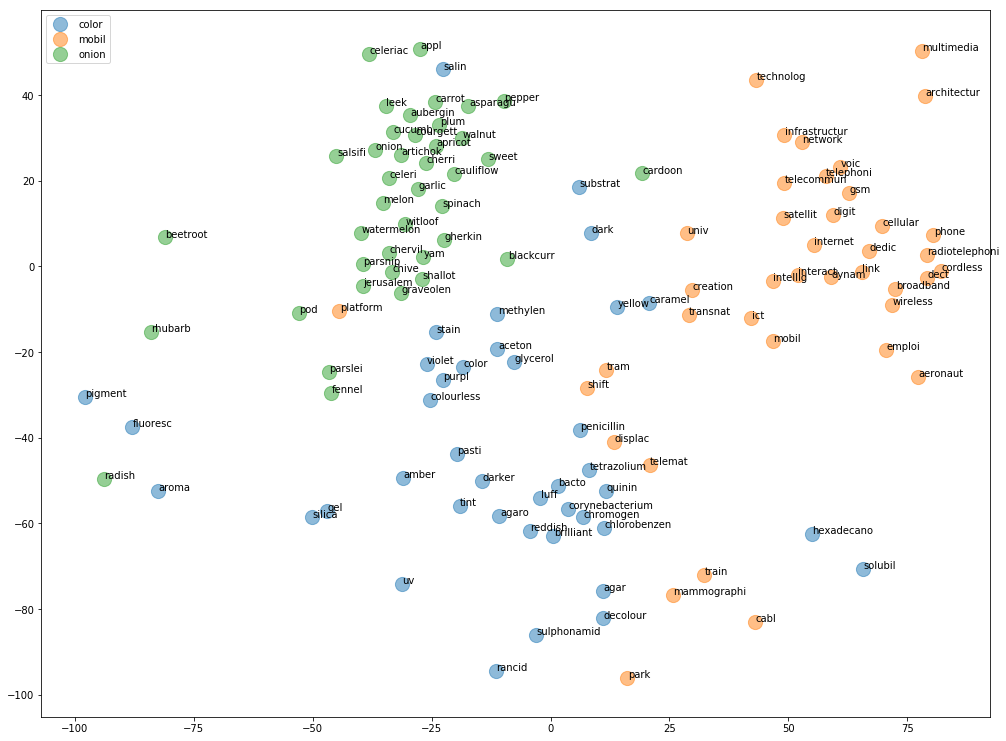

In [62]:
plt.figure(figsize=(17, 13))

for i in range(0, TOPN * len(chosen_words), TOPN + 1):
    xs = X_w2v_tsne[i: i + TOPN, 0]
    ys = X_w2v_tsne[i: i + TOPN, 1]
    plt.scatter(xs, ys, s=200, alpha=0.5, label=X_w2v_names[i])

    for label, x, y in zip(X_w2v_names[i: i + TOPN], xs, ys):
        plt.annotate(
            label,
            xy=(x + 0.1, y + 0.1))

# plt.xlim(-0.001, 0.001)
# plt.ylim(-0.001, 0.001)
plt.legend(loc='best')
plt.savefig('pics/w2v.png', bbox_inches='tight')
plt.show()

# Sentiment analysis

In [3]:
df = pd.read_csv('data/twitter/Sentiment Analysis Dataset.csv', skiprows=[8835, 535881], encoding='utf-8')

In [4]:
data = df.drop(['ItemID', 'SentimentSource'], 1)

In [5]:
data.head()

Sentiment                                      SentimentText
0          0                       is so sad for my APL frie...
1          0                     I missed the New Moon trail...
2          1                            omg its already 7:30 :O
3          0            .. Omgaga. Im sooo  im gunna CRy. I'...
4          0           i think mi bf is cheating on me!!!   ...

### Data preprocessing

In [6]:
import re

In [7]:
X_text = data.values[:, 1]
y = data.values[:, 0].astype(np.int)

In [8]:
del data, df

In [9]:
stemmer = gs.parsing.porter.PorterStemmer()
def tokenizer(text):
    tokens = re.sub(r"[\W]", " ", text).split()
    return [stemmer.stem(token) for token in tokens]

def tokenizer_2(text):
    tokens = text.split()
    return [stemmer.stem(token) for token in tokens]

### Feature extraction

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [12]:
tfidf = TfidfVectorizer(analyzer=u'word', tokenizer=tokenizer, stop_words='english')
tfidf2 = TfidfVectorizer(analyzer=u'word', tokenizer=tokenizer_2, stop_words='english')
count = CountVectorizer(analyzer=u'word', tokenizer=tokenizer, stop_words='english')

In [31]:
%time X_tfidf = tfidf.fit_transform(X_text)
%time X_tfidf2 = tfidf2.fit_transform(X_text)

CPU times: user 3min 19s, sys: 613 ms, total: 3min 20s
Wall time: 3min 19s
CPU times: user 3min 3s, sys: 763 ms, total: 3min 4s
Wall time: 3min 3s
CPU times: user 3min 17s, sys: 737 ms, total: 3min 17s
Wall time: 3min 16s


In [13]:
%time X_count = count.fit_transform(X_text)

CPU times: user 3min 13s, sys: 643 ms, total: 3min 14s
Wall time: 3min 13s


### Classification

#### Logistic regression

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [33]:
clf = LogisticRegression(n_jobs=-1)

##### tf-idf -- only letter and digits

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, train_size=0.9)

In [114]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [115]:
y_pred = clf.predict_proba(X_test)

In [116]:
roc_auc_score(y_test, y_pred[:, 1])

0.8603418547514442

In [117]:
average_precision_score(y_test, y_pred[:, 1])

0.85464528855701771

##### tf-idf -- no filters

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf2, y, train_size=0.9)

In [35]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
y_pred = clf.predict_proba(X_test)

In [37]:
roc_auc_score(y_test, y_pred[:, 1])

0.86165541649002853

In [38]:
average_precision_score(y_test, y_pred[:, 1])

0.85791890444853236

#### Nayve Bayes

In [39]:
from sklearn.naive_bayes import MultinomialNB

In [40]:
clf = MultinomialNB(alpha=2.5)

###### Tf-idf

In [41]:
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

In [137]:
roc_auc_score(y_test, y_pred[:, 1])

0.84359529308073333

In [138]:
average_precision_score(y_test, y_pred[:, 1])

0.8393202104304387

##### tf-idf -- no filter

In [43]:
roc_auc_score(y_test, y_pred[:, 1])

0.84811844513495482

In [44]:
average_precision_score(y_test, y_pred[:, 1])

0.84520536006005809

###### Word count

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_count, y, train_size=0.9)

In [140]:
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

In [141]:
roc_auc_score(y_test, y_pred[:, 1])

0.84231065770437552

In [142]:
average_precision_score(y_test, y_pred[:, 1])

0.83520293372266952

### Visualization

In [14]:
from sklearn.feature_extraction import DictVectorizer
from wordcloud import WordCloud # https://github.com/amueller/word_cloud
from scipy import ndimage
import matplotlib.pyplot as plt

In [24]:
def draw_tag_cloud(words, freqs, suffix):
    """Draws tag cloud of found tokens"""
    twitter_mask = ndimage.imread('pics/twitter_mask.png', flatten=True).astype(np.uint)
    wc = WordCloud(width=1500, height=1500,
                   background_color='white',
                   font_path='fonts/CabinSketch-Regular.ttf',
                   mask=twitter_mask)
    
    idx_sorted_freq = np.argsort(freqs)[::-1]

    wc.fit_words(dict(zip(words[idx_sorted_freq], freqs[idx_sorted_freq])))

    plt.figure(figsize=(15, 10))
    plt.imshow(wc)
    plt.axis("off")
    plt.savefig('pics/twitter_wordcloud_{}.png'.format(suffix), dpi=150, bbox_inches='tight')
    plt.show()

In [16]:
words = np.array(count.get_feature_names())

In [17]:
freqs_pos = X_count[y == 1].sum(axis=0).A1
freqs_neg = X_count[y == 0].sum(axis=0).A1

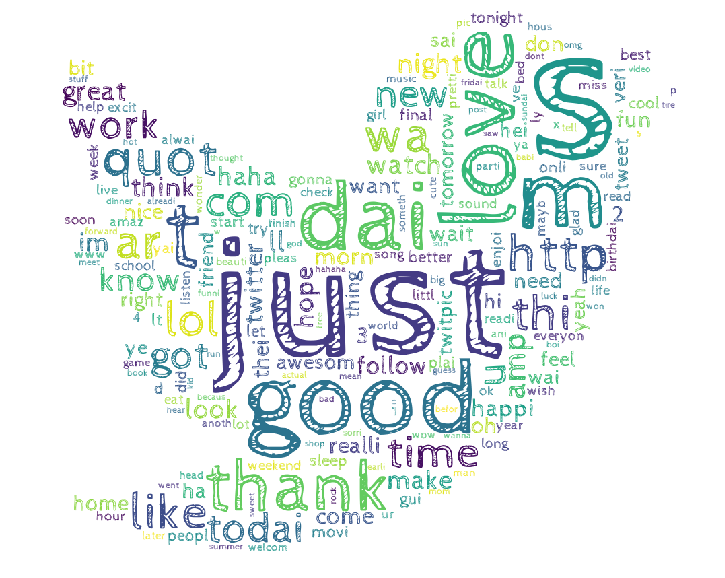

In [25]:
draw_tag_cloud(words, freqs_pos, 'pos')

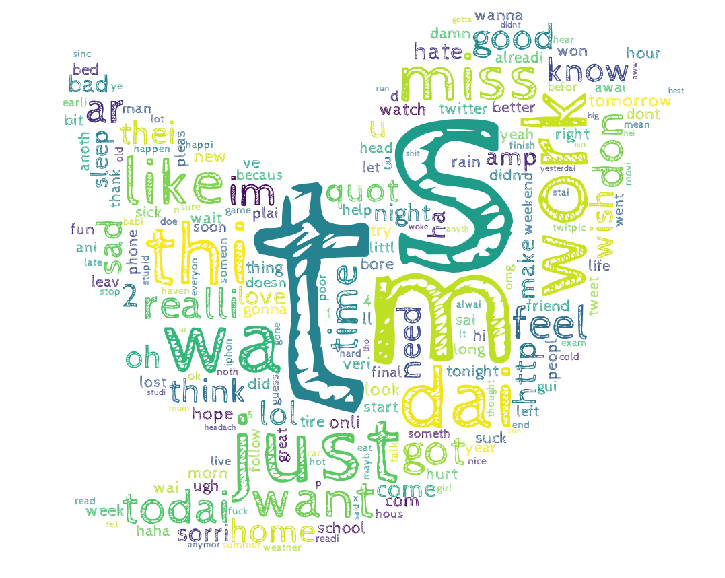

In [26]:
draw_tag_cloud(words, freqs_neg, 'neg')